


# ANÁLISIS DE LOS RESULTADOS DE LA PRUEBA OLIMPICA DE RUTA DE HOMBRES DESDE 1964 HASTA 2016

&nbsp;
En los juegos olimpicos de verano el *ciclismo* es uno de los deportes en los que se compite desde la primera edición en *Atenas 1896* con las disciplinas de *ciclimo de ruta* y  *ciclismo de pista*, al igual que los demás deportes ha tenido su evolución a través del tiempo, por ejemplo solo hasta *Los Angeles 1984* se realiza la primera prueba de ruta de mujeres y solo hasta *Seúl 1988* se realiza la primera prueba de pista de mujeres. Igualmente se han adicionado nuevas disciplinas, en *Atlanta 1996* se adiciona el *ciclismo de montaña* y en *Pekín 2008* se adiciona el *BMX*. Los principales organizadores del las pruebas de ciclismo son la *Unión Ciclista Internacional UCI*.[¹]

El siguiente análisis se enfocará en el __ciclismo de ruta__ y se analizará la prueba de __ruta individual__ de __hombres__ entre los años __1964__ y __2016__. Los datos utilizados para este análisis serán los prublicados en [ProcyclingStats](https://www.procyclingstats.com/) y se obtendrán haciendo __Web Scraping__. 



In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import folium
import seaborn as sns



## Carga de datos

Se realiza la funcion `get_table_row` que se encarga de hacer la petición de la información a la página de [ProCyclingStats](https://www.procyclingstats.com/), como los resultados de la *prueba olimpica de ruta de hombres* están organizados por año en diferentes páginas, se hace una interpolación para la variable `year`, así la función  `get_table_row` me recibe que año quiero consultar y me retornará todos los elementos `<tr>`que corresponden a las filas de la tabla de resultados para el año que estoy consultando.

In [2]:
def get_table_rows(year):
    headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'
            }

    url = f'https://www.procyclingstats.com/race/olympic-games/{year}'
    page = requests.get(url, headers=headers)

    # Solve mistake about wrong closures
    content = page.content.decode("utf-8").replace('</th>', '</td>')
    soup = BeautifulSoup(content, 'html.parser')
    return soup.find_all('tr')
    

Una vez obtenidas las filas con los resultados, es necesario ordenar cada elemento (fila) y extraer todos los atributos de esta. Los datos que ofrece la mayoria de los resultados de *la prueba olimpica de ruta de hombres* y que se analizarán son:

- *Position*:  Se refiere a la posición en la que ha llegado un corredor al finalizar la prueba, existen dos tags en este dato *DNF* que hace referencia a los ciclistas que no han terminado la prueba y *OTL* que hace referencia a los ciclistas que han terminado la prueba fuera del tiempo permitido.

- *Rider*: Nombre del ciclista que compite en la prueba.

- *Age*: Edad del ciclista el día de la competencia.

- *Team*: Equipo al que pertence el ciclista (en el que compite de manera profesional), para el año 2016 se toma como equipo el país para el que compite.

- *Nation*: País por el que compite el ciclista.

- *UciPoints*: Puntos UCI que ha obtenido el ciclista, con base en la posición que ha ocupado en la competencia. Los puntos UCI son los que utiliza la UCI para realizar el ranking anual de los ciclistas, los puntos UCI son concedidos en todas las competencias del año ciclista.

La función `extract_order_row` extrae y organiza para cada fila (que representa un ciclista en la competencia) los atributos mencionados anteriormente.

In [3]:
def extract_order_row(tableRow, year): 
    datos = tableRow.find_all('td')
    
    if(len(datos) == 0):
        return
    
    #Position
    position = datos[0].get_text().replace('\xa0', '')
    # Solve mistake about out of range position
    if (position.isdigit() and int(position) > 150):
        position = "DNF"
    
    # Delete column that comes only in 2016
    if(year == "2016"):
        del(datos[1])
    
    #Rider
    tmpTeam = datos[1].find_all('span', class_='teammob')[0].text
    rider = datos[1].get_text().replace(tmpTeam, '')
    
    #Age
    age = datos[2].get_text()
    
    #Team
    team = datos[3].get_text()
    
    #Nation
    nation = tableRow.attrs.get('data-nation')
    
    #UCI points
    if(int(year) < 1996):
        uciPoints = ''
    else:
        uciPoints = datos[4].get_text()
    
    return {'year': year,
            'position': position,  
            'rider': rider,
            'age': age,
            'team': team,
            'nation': nation,
            'uciPoints': uciPoints}

Ahora, es necesario anidar todos los resultados obtenidos en una sola tabla. La función `get_results` llama la función `extract_order_row` y va anidando todos los resultados obtenidos en una lista (`list`) llamada `results`

In [16]:
def get_results(tableRows, year):
    results = []
    for tableRow in tableRows:
        extractedRow = extract_order_row(tableRow, year)
        if extractedRow != None:
            results.append(extractedRow)
    return results
        


Ya con todas las funciones creadas, hacemos uso de ellas para obtener la información de los resultados de la *prueba olimpica de ruta de hombres* en los años listados en la variable `years`de tipo (`list`).

In [5]:
years = ['1964', '1968', '1972', '1976', '1980', '1984', '1988', '1992', '1996', '2000', '2004', '2008', '2012', '2016']
results = []

for year in years:
    tableRows = get_table_rows(year)
    results = results + get_results(tableRows, year)

Como resultado de la ejecución anterior, tengo la variable `results` con *1694* registros que tienen la siguiente estructura:

In [14]:
print(len(results))
results[0]

1694


{'year': '1964',
 'position': '1',
 'rider': '  Zanin Mario',
 'age': '24',
 'team': '',
 'nation': 'it',
 'uciPoints': ''}

Lo convierto a `DataFrame` y lo asigno a `roadCyclingResults`. A continuación se puede ver la estructura de los datos con los que se trabajará para realizar el análisis exploratorio.

In [17]:
roadCyclingResults = pd.DataFrame(results)
roadCyclingResults

,year,position,rider,age,team,nation,uciPoints
0,1964,1,Zanin Mario,24,,it,
1,1964,2,Rodian Kjell,22,,dk,
2,1964,3,Godefroot Walter,21,,be,
3,1964,4,Bilney Ray,,,au,
4,1964,5,López José Manuel,24,,es,
...,...,...,...,...,...,...,...
1689,2016,DNF,De Plus Laurens,20,Belgium,be,
1690,2016,DNF,López Miguel Ángel,22,Colombia,co,
1691,2016,DNF,Ubeto Miguel Armando,39,Venezuela,ve,
1692,2016,DNF,Moazemi Arvin,26,Iran,ir,


## Tratamiento y limpieza de los datos

Para hacer el análisis exploratorio se debe disponer de los datos con un `type` en el que se puedan tratar, según corresponda. Con el siguiente comando reivisamos que tipo de dato tiene cada columna del *DataFrame* `roadCyclingResults`.

In [18]:
roadCyclingResults.dtypes

year         object
position     object
rider        object
age          object
team         object
nation       object
uciPoints    object
dtype: object

Las columnas `year, age, uciPoint` son naturalmente números, por lo que se transformaran a tipo entero (`int`). Algunos registros no tienen valor en estos atributos, en el caso de los `uciPoints` se debe a que no todos los *ciclistas* ganaron puntos en la competencia, por lo que la ausencia de valor será reemplazada por `0`.

Podría entenderse que el atributo `position`es naturalmente un número, sin embargo algunos valores que no corresponden a datos númericos serán estudiados en el analisis exploratorio, por lo que la transformación para este campo se realizará posteriormente.

In [19]:
roadCyclingResults.year = roadCyclingResults.year.astype(int)

roadCyclingResults.age = roadCyclingResults.age.replace('', '0')
roadCyclingResults.age = roadCyclingResults.age.astype(int)

roadCyclingResults.uciPoints = roadCyclingResults.uciPoints.replace('', '0')
roadCyclingResults.uciPoints = roadCyclingResults.uciPoints.astype(int)

roadCyclingResults.dtypes

year          int64
position     object
rider        object
age           int64
team         object
nation       object
uciPoints     int64
dtype: object

Revisando nuevamente los tipos de datos del *DataFrame* `roadCyclingResults`, observamos que ya tenemos todos los datos con su tipo correspondiente.

## Análisis exploratorio

Teniendo los datos listos para ser análisados, se plantean resolver algunas preguntas acerca del comportamiento de los datos, es decir como ha sido el resultado de la *prueba olimpica de ruta de hombres entre 1964 y 2016*.

### ¿Cuántos ciclistas han terminado la *prueba olimpica de ruta de hombres* durante 1964 y 2016?

Lo primero que se quiere análisar el comportamiento en cantidad de los ciclistas que terminan la prueba, los que se retiran antes de terminarla (DNF) y los que llegan fuera de tiempo (OTL).

Se crea una función que recibe los resultados por año de la prueba y me retorna cuantos ciclistas finalizaron, cuantos se retiraron y cuantos llegaron fuera de tiempo para ese año.

In [22]:
def count_position(resultByYear):
    refPosition = ['DNF', 'OTL']
    countDNF = resultByYear[resultByYear['position'] == refPosition[0]].shape[0]
    countOTL = resultByYear[resultByYear['position'] == refPosition[1]].shape[0]
    countRiderFinished = resultByYear[~resultByYear['position'].isin(refPosition)].shape[0]
    
    newDataFrame = pd.Series({
        'RiderFinished': countRiderFinished,
        'DNF': countDNF,
        'OTL': countOTL
    })
    return newDataFrame

countResultByYear = roadCyclingResults.groupby(['year']).apply(count_position).reset_index()
countResultByYear

,year,RiderFinished,DNF,OTL
0,1964,107,0,0
1,1968,64,0,0
2,1972,76,0,0
3,1976,58,0,0
4,1980,52,0,0
5,1984,55,80,0
6,1988,109,27,0
7,1992,84,70,0
8,1996,117,66,0
9,2000,92,62,0


Para graficar los resultados linealmente y ver su evolución durante el tiempo, se debe pasar el conjunto de datos a la forma larga.

In [24]:
countResultByYearLong = countResultByYear.melt(id_vars=['year'])
countResultByYearLong.head()

,year,variable,value
0,1964,RiderFinished,107
1,1968,RiderFinished,64
2,1972,RiderFinished,76
3,1976,RiderFinished,58
4,1980,RiderFinished,52


Se grafican los resultados en función del tiempo y agrupados dependiendo del resultado final en la competencia.

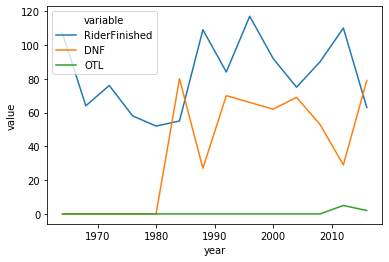

In [26]:
positionsByYear = sns.lineplot(x="year", y="value",
                  hue="variable",
                  markers=True, dashes=False, data=countResultByYearLong)
positionsByYear

Se puede observar que son *pocos* los ciclistas que llegan fuera de tiempo (OTL), mientras que desde las olimpiadas de 1984 se ve un aumento significativo de los *ciclistas* que se retiran antes de terminar la prueba (DNF), siendo para ese año mayor el número de *ciclistas* que se retiraron con respecto a los que terminaron la carrera. En la mayoria de los casos se mantiene mayor el número de *ciclistas* que termina la prueba. 

### ¿Cómo es la distribución de edades de los ciclistas que participan la *prueba olimpica de ruta de hombres* durante 1964 y 2016 ?

Otra variable interesante de análisar es la edad de los *ciclistas* durante la prueba. Comenzamos por conocer cuantos años tenia el *ciclista* más joven en participar, el más viejo y el promedio de edades de todos los *ciclistas* que han participado en la prueba entre 1964 y 2016.


In [31]:
# Ignore rider without data in age
byAgeWithoutZ = roadCyclingResults[(roadCyclingResults.age != 0)]
print(f'Edad del ciclista más joven: {byAgeWithoutZ.age.min()}')
print(f'Edad del ciclista más viejo: {byAgeWithoutZ.age.max()}')
print(f'Edad promedio de los ciclistas: {byAgeWithoutZ.age.mean()}')

Edad del ciclista más joven: 16
Edad del ciclista más viejo: 42
Edad promedio de los ciclistas: 26.223071577484365


Se grafica la distribución de las edades de los *ciclistas* participantes mediante un histograma.

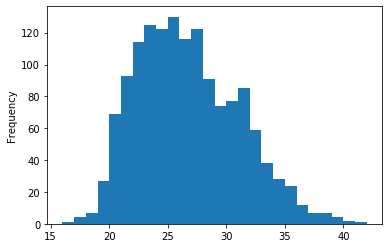

In [32]:
byAge = byAgeWithoutZ.age.plot(kind='hist', bins=26)
byAge

Se puede observar que la distribución de las edades de los *ciclistas* es asimetrica positiva con la mayoría de los *ciclistas* entre los 21 y 27 años y con otro pico importante de edades entre los 30 y 32 años.

### ¿Cómo se distribuyen geograficamente los ciclistas que participan en la *prueba olimpica de ruta de hombres* durante 1964 y 2016 ?

Se quiere saber que paises son tradicionalmente ciclistas, es importante mencionar que la cantidad de cupos otorgados a  los paises para las pruebas de ciclismo en los juegos olimpicos de verano, se define según los puntos UCI que han acumulado los *ciclistas* profesionales a lo largo de las temporadas anteriores a los juegos. 


In [34]:
byCountry = roadCyclingResults.groupby('nation').position.count().reset_index()
byCountry = byCountry.rename(columns={"position": "countRiders"})
byCountry.nation = byCountry.nation.str.upper() 
byCountry.head()

,nation,countRiders
0,AD,5
1,AE,8
2,AG,3
3,AL,1
4,AM,1


El *DataFrame* `byCountry`representa la agrupación por país del número de *ciclistas* que han participado entre 1964 y 2016 en la *prueba olimpica de ruta de hombres*. Posteriormente graficamos la distribución geografica.

In [36]:
# Incialize map
mapWorld = folium.Map(location=[0, 0], zoom_start= 2, tiles='cartodbpositron')


# Add the color for the chloropleth:
folium.Choropleth(
    geo_data='custom.geo.json',
    data=byCountry,
    columns=['nation', 'countRiders'],
    key_on='feature.properties.iso_a2',
    fill_color='YlOrRd'
).add_to(mapWorld)
mapWorld


lkdfldkflsñdf

In [15]:
def cast_to_number(cadena):
    return re.sub(r'[^0-9\.]', '0', str(cadena))

roadCyclingResults.position = roadCyclingResults.position.apply(cast_to_number)
roadCyclingResults.position = roadCyclingResults.position.replace('', '0')
roadCyclingResults.position = roadCyclingResults.position.astype(int)
roadCyclingResults.iloc[0]

def count_participations_and_better_position(riderParticipations):

    countParticipations = len(riderParticipations.year.unique())
    riderParticipations = riderParticipations.sort_values(['position'])
    riderParticipationsWithout = riderParticipations[(riderParticipations.position != 0)]
    
    try:
        betterPosition = riderParticipationsWithout.iloc[0]
    except IndexError:
        betterPosition = riderParticipations.iloc[0]
        
    newDataFrame = pd.Series({
        'nation': betterPosition.nation,
        'participations': countParticipations,
        'betterPosition': betterPosition.position,
        'yearBP': betterPosition.year,
        'ageBP': betterPosition.age
    })

    return newDataFrame

byRider = roadCyclingResults.groupby('rider').apply(count_participations_and_better_position).reset_index()
byRider = byRider.sort_values(by=['participations', 'betterPosition'], ascending= [False, True])

byRider.head()


,rider,nation,participations,betterPosition,yearBP,ageBP
334,Fischer Murilo Antonio,br,5,20,2008,29
1193,Vinokourov Alexandre,kz,4,1,2012,38
275,Dekker Erik,nl,4,2,1992,21
195,Cancellara Fabian,ch,4,3,2008,27
1251,Zabel Erik,de,4,4,1992,22


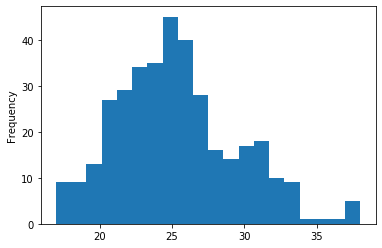

In [16]:
byAgeBetterPosition = byRider[(byRider.ageBP != 0) & (byRider.betterPosition < 3)].ageBP.plot(kind='hist', bins=20)
byAgeBetterPosition

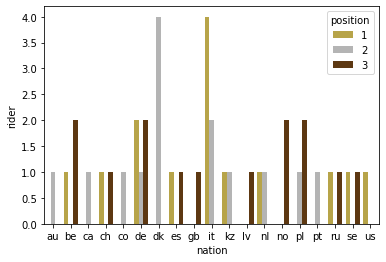

In [17]:
podiumPositions = [1, 2, 3]
podium = roadCyclingResults[roadCyclingResults['position'].isin(podiumPositions)]
podiumByCountry = podium.groupby(['nation', 'position'], as_index = False).count()
#podiumByCountry
out = sns.barplot(x='nation', y= 'rider', hue='position', data=podiumByCountry, palette=['#C9B037', '#B4B4B4', '#6A3805'])
out 



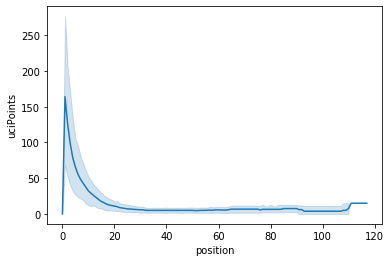

In [18]:
import matplotlib.pyplot as plt
out = sns.lineplot(x='position', y='uciPoints', data=roadCyclingResults)
out